In [1]:
# !pip install plotly
# !pip install "notebook>=5.3" "ipywidgets>=7.5"
# !pip install geopandas
# !pip install py7zr

In [2]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import plotly.graph_objects as go
import json
import warnings
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__)
pd.set_option('display.max_columns', None)

3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7


Index(['cleabs', 'code_insee', 'nom_commune', 'iris', 'code_iris', 'nom_iris',
       'type_iris', 'geometry'],
      dtype='object')
EPSG:2154


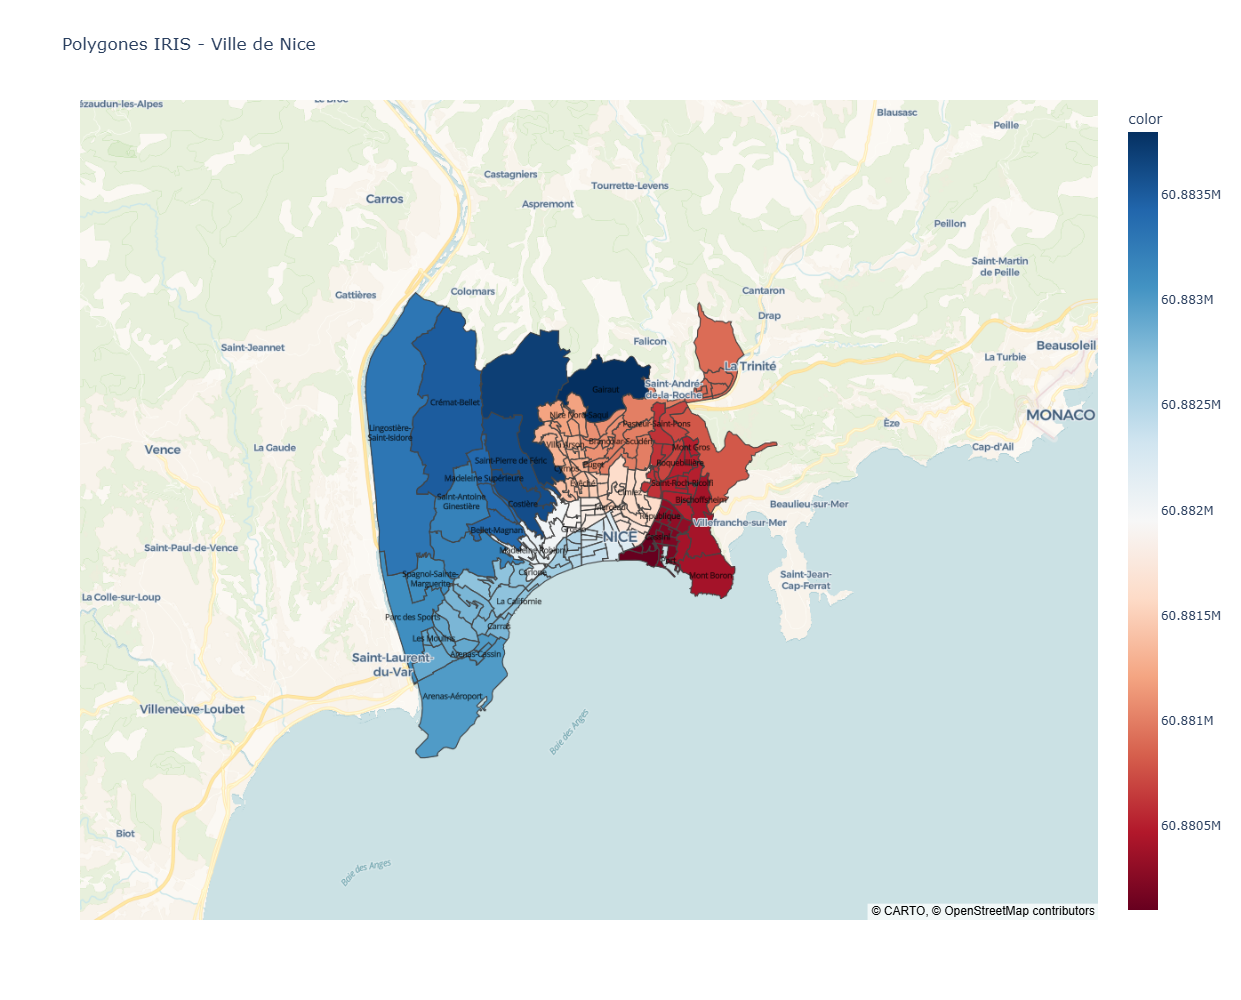

In [3]:
import geopandas as gpd
import plotly.express as px

warnings.filterwarnings('ignore', category=UserWarning) 

# Charger le fichier GeoPackage
fichier_gpkg = "contours-iris.gpkg"
gdf = gpd.read_file(fichier_gpkg)
print(gdf.columns)

# Filtrer pour Nice
gdf_nice = gdf[gdf["nom_commune"].str.lower() == "nice"]

# Convertir en WGS84
print(gdf_nice.crs)
gdf_nice = gdf_nice.to_crs(epsg=4326)

# Créer le GeoJSON
geojson_data = gdf_nice.__geo_interface__

gdf_nice["fid"]=gdf_nice.index

# Créer la carte avec choropleth_map
fig = px.choropleth_map(
    gdf_nice,
    geojson=geojson_data,
    locations=gdf_nice["fid"],
    color=gdf_nice["code_iris"].astype(np.float32),  # Remplacez par l'attribut souhaité
    color_continuous_scale="RdBu",
    center={
        "lat": gdf_nice.geometry.centroid.y.mean(),
        "lon": gdf_nice.geometry.centroid.x.mean()
    },
    zoom=11,
    title="Polygones IRIS - Ville de Nice",
    height=1000,  # ✅ Augmente la hauteur
    width=None,   # ✅ Augmente la largeur
    opacity=1,
    hover_name="nom_iris",  # Titre dans le hover
    hover_data={
        "code_iris": True,
        "nom_iris": False,
        "type_iris": True,
        "cleabs": True,
        "fid": False,
    },

)

gdf_nice_l93 = gdf_nice.to_crs(2154)
pts_l93 = gdf_nice_l93.geometry.representative_point()
pts = pts_l93.to_crs(4326)  # lon/lat

fig.add_trace(
    go.Scattermap(
        lon=pts.x,
        lat=pts.y,
        text=gdf_nice["nom_iris"].astype(str),
        mode="text",
        textfont=dict(color="black", size=8),
        hoverinfo="skip",        # on garde le hover de la choropleth
        showlegend=False,
        textposition="middle center",
    )
)

fig.update_geos(
    fitbounds="locations",
    visible=False,       # masque la carte
    showcountries=False,
    showland=False,
    showocean=False,
    showlakes=False,
    showrivers=False,
)


# fig.update_layout(
#     template="plotly_white",       # thème clair
#     paper_bgcolor="white",         # fond du canvas
#     plot_bgcolor="white",          # fond de la zone de tracé
#     geo=dict(bgcolor="rgba(0,0,0,0)")  # transparent si tu préfères
# )


fig.show()
